# Model Optimization

```{important}
Remember that best is context dependent and relative.  The best accuracy might not be the best overall. Automatic optimization can only find the best thing in terms of a single score.
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import cluster
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree

## Model validation
We will work with the iris data again.

In [2]:
iris_df = sns.load_dataset('iris')


iris_X = iris_df.drop(columns=['species'])

iris_y = iris_df['species']

We will still use the test train split to keep our test data separate from the data that we use to find our preferred parameters.

In [3]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X,iris_y,
                                                                        random_state=0)

````{margin}
```{admonition} Further Reading
the criteria are discussed [in the mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) of the sklearn documentation
```
````

Today we will optimize a decision tree over three parameters. One is the criterion, which is how it decides where to create thresholds in parameters. Gini is the default and it computes how concentrated each class is at that node, another is entropy, entropy is, generally how random something is.  Intuitively these do similar things, which makes sense because they are two ways to make the same choice, but they have slightly different calculations.

The other two parameters we have seen some before. Max depth is the height of the tree and min smaples per leaf makes it keeps the leaf sizes small.

In [4]:
dt = tree.DecisionTreeClassifier()
params_dt = {'criterion':['gini','entropy'],'max_depth':[2,3,4],
       'min_samples_leaf':list(range(2,20,2))}

We will fit it with default CV settings.

In [5]:
dt_opt = GridSearchCV(dt,params_dt)

then we can fit

In [6]:
dt_opt.fit(iris_X_train,iris_y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18]})

we can use ti to get predictions

In [7]:
y_pred = dt_opt.predict(iris_X_test)

we can also score it as regular.

In [8]:
dt_opt.score(iris_X_test,iris_y_test)

0.9473684210526315

we can also see the best parameters.

In [9]:
dt_opt.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

we can look at the overall results this way:

In [10]:
dt_5cv_df = pd.DataFrame(dt_opt.cv_results_)
dt_5cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002178,0.000390,0.001547,0.000050,gini,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.956522,0.913043,1.0,0.909091,0.954545,0.94664,0.033305,5
1,0.002276,0.000247,0.001661,0.000232,gini,2,4,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.956522,0.913043,1.0,0.909091,0.954545,0.94664,0.033305,5
2,0.002110,0.000162,0.001603,0.000256,gini,2,6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.956522,0.913043,1.0,0.909091,0.954545,0.94664,0.033305,5
3,0.002046,0.000058,0.001468,0.000009,gini,2,8,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.956522,0.913043,1.0,0.909091,0.954545,0.94664,0.033305,5
4,0.002112,0.000185,0.001563,0.000186,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.956522,0.913043,1.0,0.909091,0.954545,0.94664,0.033305,5


To see more carefully what it does, we can look at its shape.

In [11]:
dt_5cv_df.shape

(54, 16)

we can see that the total number of rows matched the product of the length of each list of parameters to try.

In [12]:
np.product([len(param_list) for param_list in params_dt.values()])

54

This means that it tests every combination of features-- without us writing a bunch of nested loops.

We can also plot the dta and look at the performance.

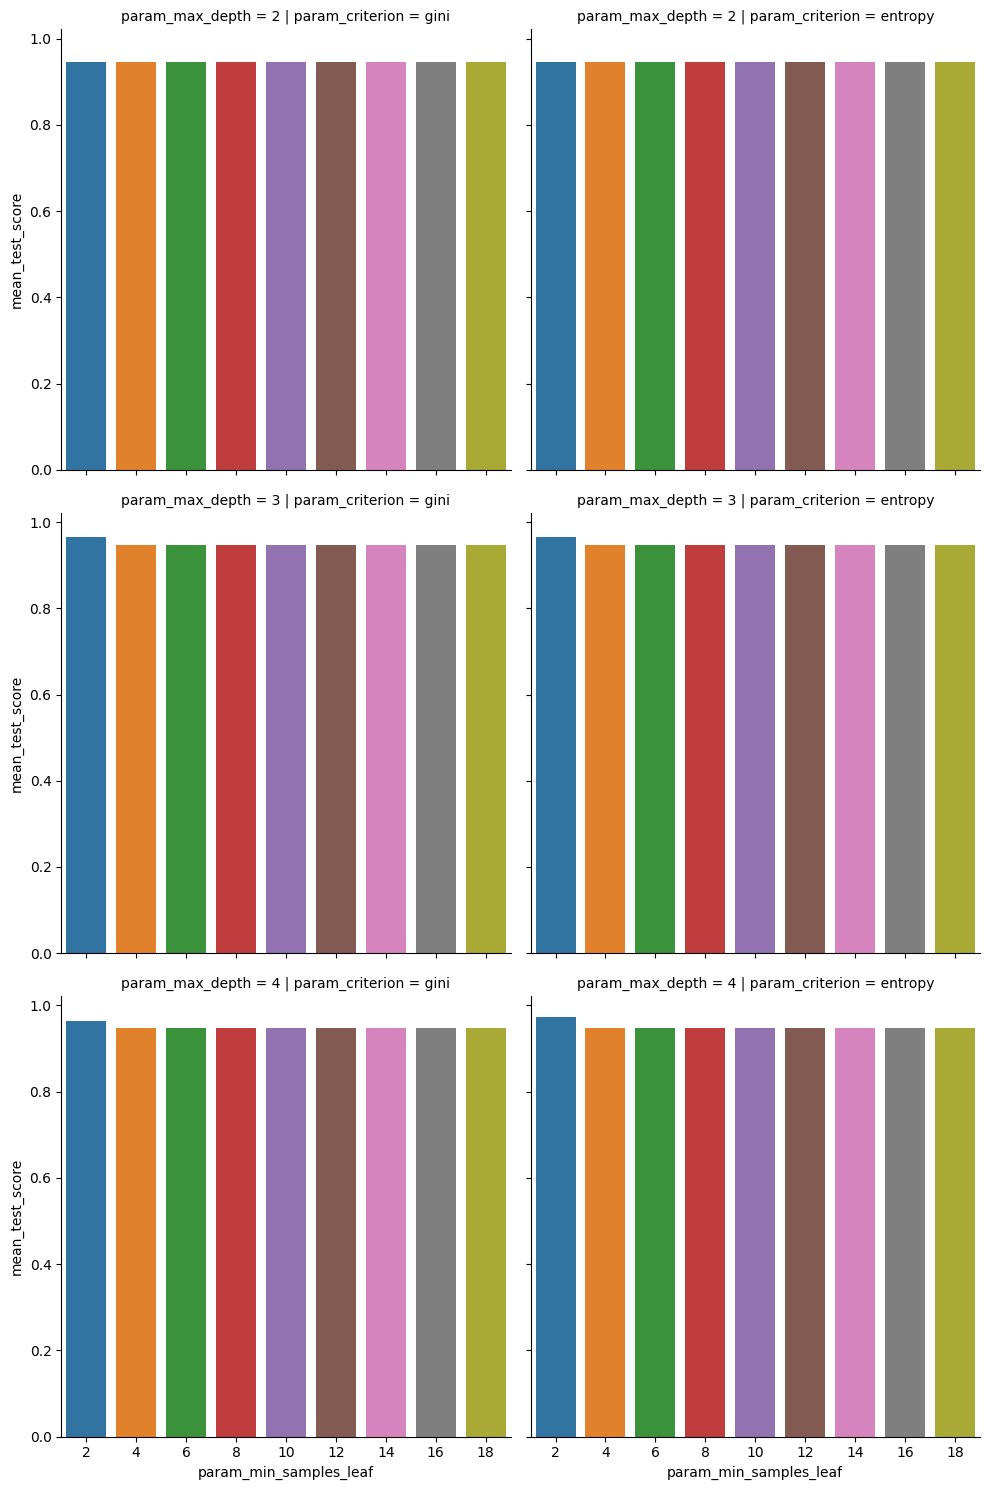

In [13]:
sns.catplot(data=dt_5cv_df,x='param_min_samples_leaf',y='mean_test_score',
           col='param_criterion', row= 'param_max_depth', kind='bar',)

this makes it clear that none of these stick out much in terms of performance.



## Impact of CV parameters

In [14]:
dt_opt10 = GridSearchCV(dt,params_dt,cv=10)
dt_opt10.fit(iris_X_train,iris_y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18]})

In [15]:
dt_10cv_df = pd.DataFrame(dt_opt10.cv_results_)

We can stack the columns we want from the two results together with a new indicator column `cv`

In [16]:
plot_cols = ['param_min_samples_leaf','std_test_score','mean_test_score',
             'param_criterion','param_max_depth','cv']
dt_10cv_df['cv'] = 10
dt_5cv_df['cv'] = 5

dt_cv_df = pd.concat([dt_5cv_df[plot_cols],dt_10cv_df[plot_cols]])
dt_cv_df.head()

,param_min_samples_leaf,std_test_score,mean_test_score,param_criterion,param_max_depth,cv
0,2,0.033305,0.94664,gini,2,5
1,4,0.033305,0.94664,gini,2,5
2,6,0.033305,0.94664,gini,2,5
3,8,0.033305,0.94664,gini,2,5
4,10,0.033305,0.94664,gini,2,5


this can be used to plot.

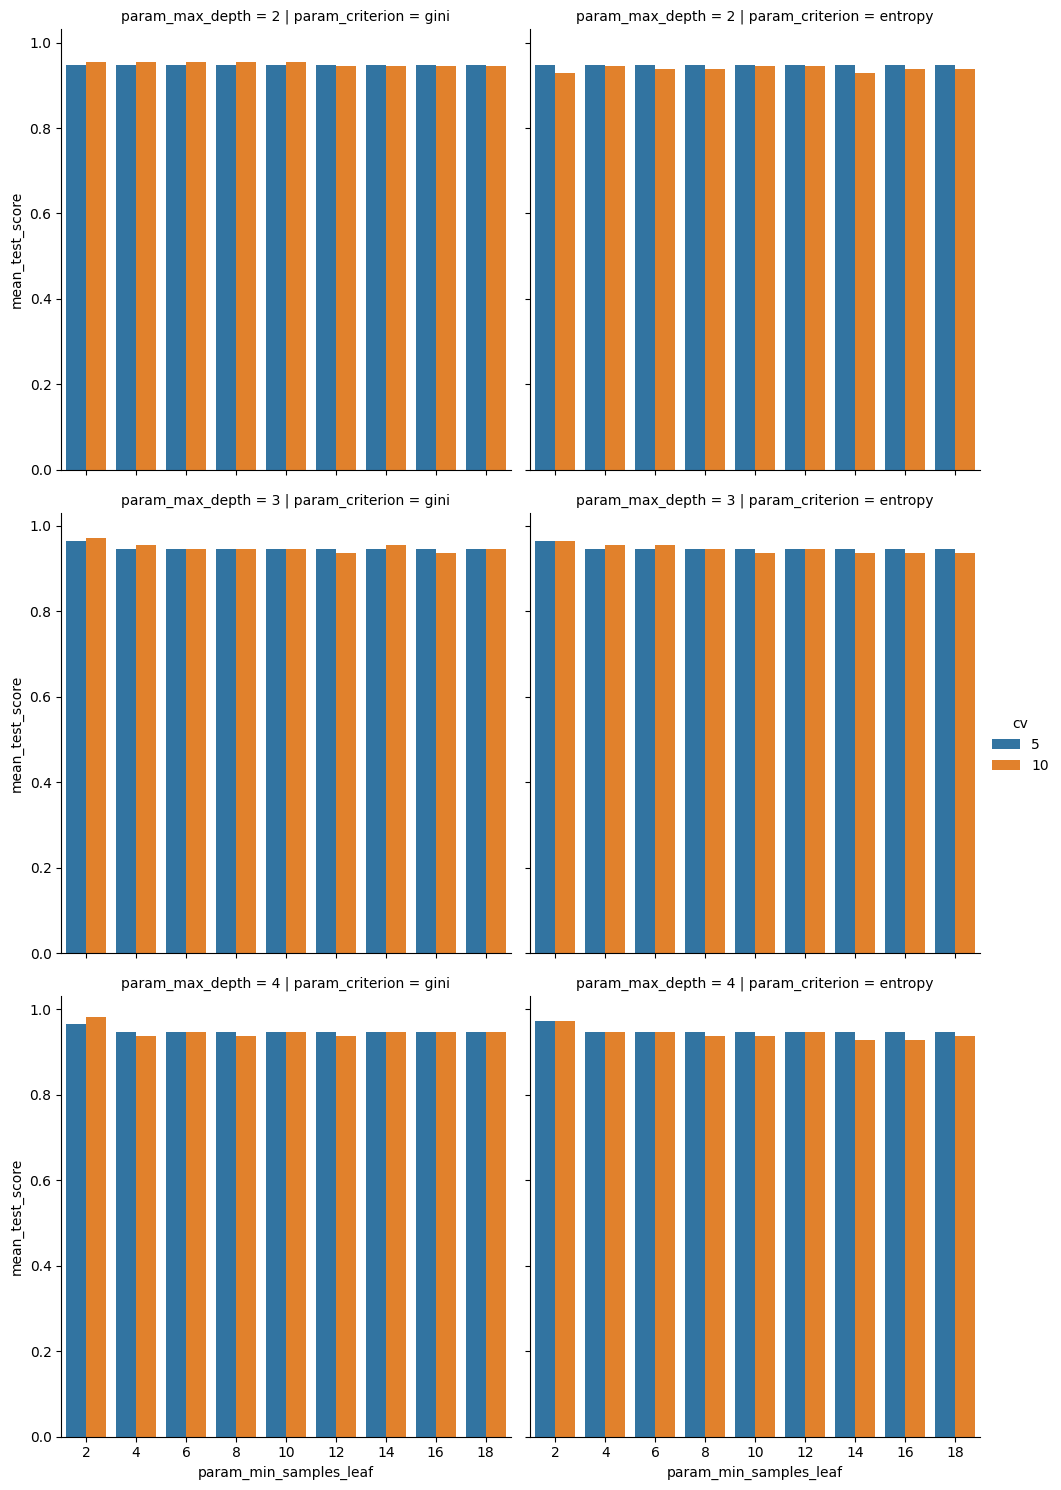

In [17]:
sns.catplot(data=dt_cv_df,x='param_min_samples_leaf',y='mean_test_score',
           col='param_criterion', row= 'param_max_depth', kind='bar',
           hue = 'cv')

we see that the mean scores are not very different, but that 10 is a little higher in some cases.  This makes sense, it has more data to learn from, so it found something that applied better, on average, to the test set.

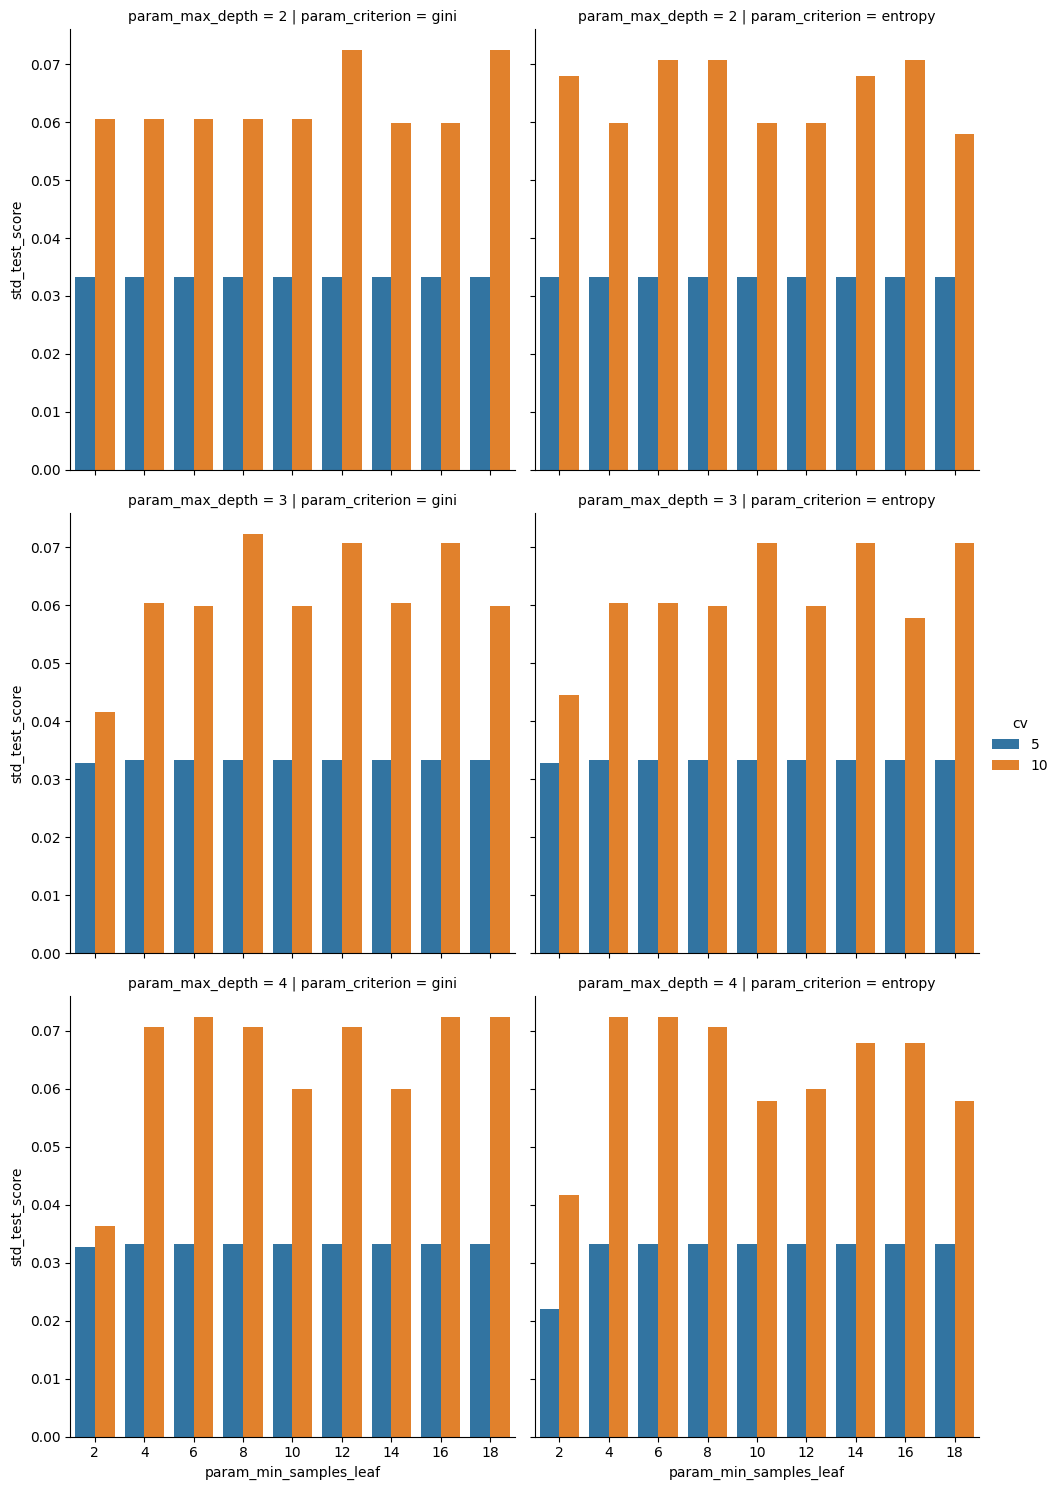

In [18]:
sns.catplot(data=dt_cv_df,x='param_min_samples_leaf',y='std_test_score',
           col='param_criterion', row= 'param_max_depth', kind='bar',
           hue = 'cv')

However here we see that the variabilty in those scores is much higher, so maybe the 5 is better.

We can compare to see if it finds the same model as best:

In [19]:
dt_opt.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

In [20]:
dt_opt10.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}

In some cases they will and others they will not.

In [21]:
dt_opt.score(iris_X_test,iris_y_test)

0.9473684210526315

In [22]:
dt_opt10.score(iris_X_test,iris_y_test)

0.9736842105263158

In some cases they will find the same model and score the same, but it other time they will not.

The takeaway is that the cross validation parameters impact our ability to measure the score and possibly how close that cross validation mean score will match the true test score. Mostly it will change the variability in the estimate of the score.  It does not change necessarily which model is best, that is up to the data iteself (the original test/train split would impact this).

```{admonition} Try it yourself
Does this vary if you repeat this with different test sets? How much does it depend on that? Does repeating it produce the same scores? Does one take longer to fit or score?
```



## Other searches

In [23]:
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut

In [24]:
rand_opt = model_selection.RandomizedSearchCV(dt,params_dt).fit(iris_X_train,
                                                     iris_y_train)

In [25]:
rand_opt.score(iris_X_test,iris_y_test)

0.9473684210526315

In [26]:
rand_opt.best_params_

{'min_samples_leaf': 2, 'max_depth': 4, 'criterion': 'gini'}

It might find the same solution, but it also might not.  If you do some and see that the parameters overall do not impact the scores much, then you can trust whichever one, or consider other criteria to choose the best model to use.

## Questions after class

### What does cross-validation do that clustering doesn't?

Cross validation can be used *with* clustering if you want.  Cross validation is a technique for evaluating how well a model performs; in this case we are combining with a search to find the best parameters.

### Is grid search commonly used or is it too expensive for more realistically sized datasets?

Grid search is realistic for simple models.  It becomes more expensive with models that have more options for parameters. For example a parameter that can be continuously valued or take a large range, there become too many to test, so we use the random search or something else. The cost does go up some with larger datasets, but this scales primarily with the nubmer of parameters and values for each.

For example, bayesian optimization is a more complex type of random search.

### What is the difference between gini and entropy?

the criteria are discussed [in the mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) of the sklearn documentation

### Is it more accurate to do cross vaididation or test_train_split?

Ideally both: use train test split to set aside a test set for the value that you will report when you say this is how good my final model is and cross validation to choose which model you call the final model.